## HMW5

In [1]:
!gdown 17eLq5Ng5yfbX9tLq2tdiOdscO0ea8xK5
!gdown 1Y-68UagW14hwJXNyaR2HnML5jEwvjQlj
!gdown 1P_HLLvGq15gsgDl5P6QYrHkTlkcytMdr

Downloading...
From: https://drive.google.com/uc?id=17eLq5Ng5yfbX9tLq2tdiOdscO0ea8xK5
To: /content/train.csv
100% 951k/951k [00:00<00:00, 136MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Y-68UagW14hwJXNyaR2HnML5jEwvjQlj
To: /content/valid.csv
100% 105k/105k [00:00<00:00, 68.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1P_HLLvGq15gsgDl5P6QYrHkTlkcytMdr
To: /content/test.csv
100% 444k/444k [00:00<00:00, 151MB/s]


In [2]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


### Question 1

Steps 
*   Cleaning sentences
*   Train Word2Vec model using cleaned sentences
*   Tokenizing word to get sentences as sequence of numbers
*   Padding sequences to make all sentences have same size
*   Make weight matrix


In [3]:
import pandas as pd
import numpy as np

In [4]:
train_input = pd.read_csv('train.csv')
val_input = pd.read_csv('valid.csv')
test_input = pd.read_csv('test.csv')

In [5]:
def clean_sentence(input_sentence):
  tokens = input_sentence.split(' ')
  translation_table = str.maketrans('', '', "\"#$%&'()*+,-/:;<=>?@[\]^_`{|}~،؟!❊#$٪^&*)(ـ+=-؛:{}")
  tokens = [w.translate(translation_table) for w in tokens]
  tokens = [word for word in tokens if word.isalpha()]
  return tokens

In [6]:
def create_sentence(input_df):
  sentences = []
  for index,row in input_df.iterrows():
    sentences.append(clean_sentence(row.sentence1))
    sentences.append(clean_sentence(row.sentence2))
  return sentences

In [7]:
train_sentences = create_sentence(train_input)
test_sentences = create_sentence(test_input)
valid_sentences = create_sentence(val_input)

In [8]:
len(train_sentences)

7338

In [9]:
from gensim.models import Word2Vec

In [10]:
model = Word2Vec(sentences=train_sentences, size=300, window=5, min_count=1, workers=4,sg=1)

In [11]:
model.save('train_w2v.model')

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

1. fit_on_texts: Updates internal vocabulary based on a list of texts. This method 
creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).

2. texts_to_sequences Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. Nothing more, nothing less, certainly no magic involved.


Why don't combine them? Because you almost always fit once and convert to sequences many times. You will fit on your training corpus once and use that exact same word_index dictionary at train / eval / testing / prediction time to convert actual text into sequences to feed them to the network. So it makes sense to keep those methods separate.

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentences)

train_tokens = tokenizer.texts_to_sequences(train_sentences)
test_tokens = tokenizer.texts_to_sequences(test_sentences)
valid_tokens = tokenizer.texts_to_sequences(valid_sentences)

In [14]:
train_tokens[:3]

[[1276, 400, 27, 1701, 1105, 15, 196, 1, 768, 3, 3321, 5314, 27],
 [1524, 2, 137, 21, 72, 1, 768, 1276, 400, 27, 1701, 3, 3321, 5314, 27],
 [5315, 1525, 5316, 99, 1702, 1, 2160, 2, 3322, 4, 9]]

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

pad_sequences is used to ensure that all sequences in a list have the same length. By default this is done by padding 0 in the beginning of each sequence until each sequence has the same length as the longest sequence.

In [17]:
max_length = max([len(x) for x in train_tokens])

In [18]:
max_length

29

In [19]:
MAX_SEQ_LENGTH = 30

In [20]:
train_sequences = pad_sequences(train_tokens, maxlen=MAX_SEQ_LENGTH, padding='post')
valid_sequences = pad_sequences(valid_tokens, maxlen=MAX_SEQ_LENGTH, padding='post')
test_sequences = pad_sequences(test_tokens, maxlen=MAX_SEQ_LENGTH, padding='post')

In [21]:
def get_weight_matrix(word2vec, vocab_size, vocab):
    weight_matrix = np.zeros((vocab_size, 300))
    for word, i in vocab.items():
      try:
        weight_matrix[i] = word2vec[word]
      except KeyError:
        continue
    return weight_matrix

In [22]:
weight_matrix = get_weight_matrix(model, len(tokenizer.word_index)+1, tokenizer.word_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


split sentences because our model has two inputs.

In [23]:
train_sent1_seq = train_sequences[:len(train_input)]
train_sent2_seq = train_sequences[len(train_input): len(train_input) * 2]
val_sent1_seq = valid_sequences[:len(val_input)]
val_sent2_seq = valid_sequences[len(val_input):len(val_input) * 2]
test_sent1_seq = test_sequences[:len(test_input)]
test_sent2_seq = test_sequences[len(test_input): len(test_input) * 2]

In [24]:
y_train = np.array(train_input['label'].tolist()).reshape((-1,1))
y_valid = np.array(val_input['label'].tolist()).reshape((-1,1))
y_test = np.array(test_input['label'].tolist()).reshape((-1,1))

### Question 2 

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, GRU, Concatenate, Flatten, Dropout, Input
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Recall, Precision

In [26]:
vocab_size = len(tokenizer.word_index) + 1
embed_size = 300
MAX_SEQ_LENGTH = 30

In [27]:
class attention(Layer):
    def __init__(self, **kwargs):
        super(attention, self).__init__(**kwargs)

    def build(self, input_shape):

        self.W = self.add_weight(name="attention_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="attention_bias", shape=(input_shape[1], 1), initializer="zeros")      

        super(attention, self).build(input_shape)

    def call(self, x):

        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et)
        at = K.expand_dims(at, axis=-1)
        output = x * at
        # return K.sum(output, axis=1)
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [28]:
def create_model():

  # mask_zero=True for the Embedding layer does not result in returning a zero vector.it would return the embedding vector with index zero. 
  embedding_layer = Embedding(vocab_size, embed_size, input_length = MAX_SEQ_LENGTH, weights = [weight_matrix], mask_zero = True, name='Embeddinglayer')
  bilstm_layer = Bidirectional(LSTM(embed_size, dropout = 0.2,activation='tanh',return_sequences=True, recurrent_dropout=0.5))
  attention_layer = attention()

  # sentence1
  sent1_input = Input(shape=(MAX_SEQ_LENGTH,), name='sentence1')
  sent1_emb = embedding_layer(sent1_input)
  sent1_bilstm = bilstm_layer(sent1_emb)
  sent1_att = attention_layer(sent1_bilstm)

  # sentence2
  sent2_input = Input(shape=(MAX_SEQ_LENGTH,), name='sentence2')
  sent2_emb = embedding_layer(sent2_input)
  sent2_bilstm = bilstm_layer(sent2_emb)
  sent2_att = attention_layer(sent2_bilstm)

  # concating two sentences
  concat_layer = Concatenate(name='concatenate', axis=1)([sent1_att, sent2_att])
  flatten = Flatten()(concat_layer)

  # desne layers
  drop_layer1 = Dropout(0.2,name='Dropout1')(flatten)
  dense_layer1 = Dense(128, activation='relu', name='DenseLayer1')(drop_layer1)
  dense_layer2 = Dense(64, activation='relu', name='DenseLayer2')(dense_layer1)
  dense_layer3 = Dense(32, activation='relu', name='DenseLayer3')(dense_layer2)
  drop_layer2 = Dropout(0.2,name='Dropout2')(dense_layer3)

  output = Dense(1, activation='sigmoid', name='OutputLayer')(drop_layer2)

  model = Model([sent1_input, sent2_input], output)

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall(), Precision()])

  return model

In [29]:
bilstm_model = create_model()
bilstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sentence1 (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 sentence2 (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 Embeddinglayer (Embedding)     (None, 30, 300)      3605100     ['sentence1[0][0]',              
                                                                  'sentence2[0][0]']              
                                                                                                  
 bidirectional (Bidirectional)  (None, 30, 600)      1442400     ['Embeddinglayer[0][0]',     

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [33]:
checkpoint_path = '/content/drive/MyDrive/model_bilstm_hw5-{epoch:03d}-{val_accuracy:03f}.ckpt'

cp_callback = ModelCheckpoint(filepath=checkpoint_path, monitor = 'val_accuracy', mode = 'max', save_best_only=True)

In [34]:
bilstm_history = bilstm_model.fit([train_sent1_seq, train_sent2_seq], y_train,
                    epochs=30,
                    validation_data=([val_sent1_seq, val_sent2_seq], y_valid),
                    batch_size=128,
                    callbacks=[cp_callback])

Epoch 1/30
29/29 [==============================] - 26s 917ms/step - loss: 0.6335 - accuracy: 0.6708 - recall: 1.0000 - precision: 0.6708 - val_loss: 0.6013 - val_accuracy: 0.7174 - val_recall: 1.0000 - val_precision: 0.7174
Epoch 2/30
29/29 [==============================] - 14s 487ms/step - loss: 0.6262 - accuracy: 0.6708 - recall: 1.0000 - precision: 0.6708 - val_loss: 0.6148 - val_accuracy: 0.7174 - val_recall: 1.0000 - val_precision: 0.7174
Epoch 3/30
29/29 [==============================] - 14s 475ms/step - loss: 0.6194 - accuracy: 0.6667 - recall: 0.9659 - precision: 0.6761 - val_loss: 0.6051 - val_accuracy: 0.7174 - val_recall: 1.0000 - val_precision: 0.7174
Epoch 4/30
29/29 [==============================] - 14s 481ms/step - loss: 0.5233 - accuracy: 0.7375 - recall: 0.9065 - precision: 0.7527 - val_loss: 0.7129 - val_accuracy: 0.7076 - val_recall: 0.9726 - val_precision: 0.7190
Epoch 5/30
29/29 [==============================] - 14s 484ms/step - loss: 0.3581 - accuracy: 0.8441

In [35]:
import matplotlib.pyplot as plt

In [36]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

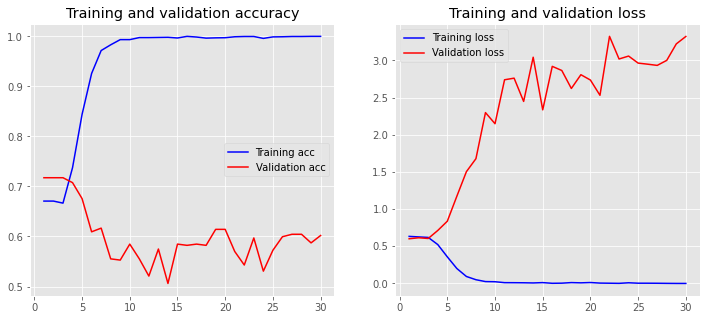

In [37]:
plot_history(bilstm_history)

In [39]:
from keras.models import load_model
bilstm_model = load_model('/content/drive/MyDrive/model_bilstm_hw5-001-0.717445.ckpt')

In [40]:
bilstm_model.evaluate([test_sent1_seq, test_sent2_seq], y_test)
bilstm_preds = bilstm_model.predict([test_sent1_seq, test_sent2_seq])

54/54 [==============================] - 5s 76ms/step


In [41]:
from sklearn.metrics import classification_report

In [42]:
y_bilstm_pred = np.where(bilstm_preds > 0.5, 1, 0)
print(classification_report(y_test, y_bilstm_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       578
           1       0.66      1.00      0.80      1147

    accuracy                           0.66      1725
   macro avg       0.33      0.50      0.40      1725
weighted avg       0.44      0.66      0.53      1725



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Question 3

#### LSTM

In [43]:
def create_model():

  # mask_zero=True for the Embedding layer does not result in returning a zero vector.it would return the embedding vector with index zero. 
  embedding_layer = Embedding(vocab_size, embed_size, input_length = MAX_SEQ_LENGTH, weights = [weight_matrix], mask_zero = True, name='Embeddinglayer')
  lstm_layer = LSTM(embed_size, dropout = 0.2,activation='tanh',return_sequences=True, recurrent_dropout=0.5)
  attention_layer = attention()

  # sentence1
  sent1_input = Input(shape=(MAX_SEQ_LENGTH,), name='sentence1')
  sent1_emb = embedding_layer(sent1_input)
  sent1_lstm = lstm_layer(sent1_emb)
  sent1_att = attention_layer(sent1_lstm)

  # sentence2
  sent2_input = Input(shape=(MAX_SEQ_LENGTH,), name='sentence2')
  sent2_emb = embedding_layer(sent2_input)
  sent2_lstm = lstm_layer(sent2_emb)
  sent2_att = attention_layer(sent2_lstm)

  # concating two sentences
  concat_layer = Concatenate(name='concatenate', axis=1)([sent1_att, sent2_att])
  flatten = Flatten()(concat_layer)

  # desne layers
  drop_layer1 = Dropout(0.2,name='Dropout1')(flatten)
  dense_layer1 = Dense(128, activation='relu', name='DenseLayer1')(drop_layer1)
  dense_layer2 = Dense(64, activation='relu', name='DenseLayer2')(dense_layer1)
  dense_layer3 = Dense(32, activation='relu', name='DenseLayer3')(dense_layer2)
  drop_layer2 = Dropout(0.2,name='Dropout2')(dense_layer3)

  output = Dense(1, activation='sigmoid', name='OutputLayer')(drop_layer2)

  model = Model([sent1_input, sent2_input], output)

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall(), Precision()])

  return model

In [44]:
lstm_model = create_model()
lstm_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sentence1 (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 sentence2 (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 Embeddinglayer (Embedding)     (None, 30, 300)      3605100     ['sentence1[0][0]',              
                                                                  'sentence2[0][0]']              
                                                                                                  
 lstm_1 (LSTM)                  (None, 30, 300)      721200      ['Embeddinglayer[0][0]',   

In [45]:
checkpoint_path = '/content/drive/MyDrive/model_lstm_hw5-{epoch:03d}-{val_accuracy:03f}.ckpt'

cp_callback = ModelCheckpoint(filepath=checkpoint_path, monitor = 'val_accuracy', mode = 'max', save_best_only=True)

In [46]:
history_lstm = lstm_model.fit([train_sent1_seq, train_sent2_seq], y_train,
                    epochs=30,
                    validation_data=([val_sent1_seq, val_sent2_seq], y_valid),
                    batch_size=128,
                    callbacks=[cp_callback])

Epoch 1/30
29/29 [==============================] - 19s 445ms/step - loss: 0.6481 - accuracy: 0.6609 - recall_1: 0.9711 - precision_1: 0.6708 - val_loss: 0.6140 - val_accuracy: 0.7174 - val_recall_1: 1.0000 - val_precision_1: 0.7174
Epoch 2/30
29/29 [==============================] - 7s 246ms/step - loss: 0.6383 - accuracy: 0.6708 - recall_1: 1.0000 - precision_1: 0.6708 - val_loss: 0.6027 - val_accuracy: 0.7174 - val_recall_1: 1.0000 - val_precision_1: 0.7174
Epoch 3/30
29/29 [==============================] - 7s 255ms/step - loss: 0.6313 - accuracy: 0.6708 - recall_1: 1.0000 - precision_1: 0.6708 - val_loss: 0.5998 - val_accuracy: 0.7174 - val_recall_1: 1.0000 - val_precision_1: 0.7174
Epoch 4/30
29/29 [==============================] - 8s 268ms/step - loss: 0.6124 - accuracy: 0.6762 - recall_1: 0.9976 - precision_1: 0.6750 - val_loss: 0.6713 - val_accuracy: 0.6634 - val_recall_1: 0.8801 - val_precision_1: 0.7159
Epoch 5/30
29/29 [==============================] - 7s 251ms/step - los

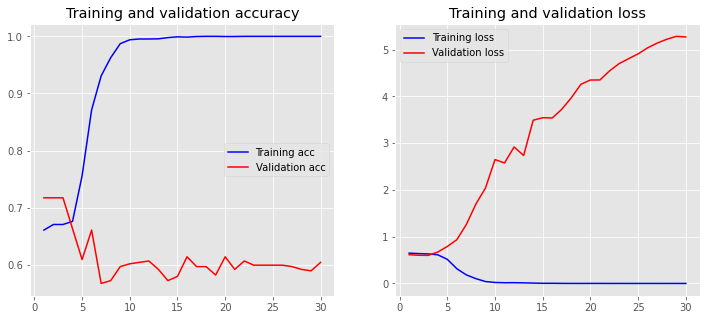

In [47]:
plot_history(history_lstm)

In [48]:
from keras.models import load_model
lstm_model = load_model('/content/drive/MyDrive/model_lstm_hw5-001-0.717445.ckpt')

In [49]:
lstm_model.evaluate([test_sent1_seq, test_sent2_seq], y_test)
lstm_preds = lstm_model.predict([test_sent1_seq, test_sent2_seq])

54/54 [==============================] - 3s 38ms/step


In [50]:
y_lstm_pred = np.where(lstm_preds > 0.5, 1, 0)
print(classification_report(y_test, y_lstm_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       578
           1       0.66      1.00      0.80      1147

    accuracy                           0.66      1725
   macro avg       0.33      0.50      0.40      1725
weighted avg       0.44      0.66      0.53      1725



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### GRU

In [51]:
def create_model():

  # mask_zero=True for the Embedding layer does not result in returning a zero vector.it would return the embedding vector with index zero. 
  embedding_layer = Embedding(vocab_size, embed_size, input_length = MAX_SEQ_LENGTH, weights = [weight_matrix], mask_zero = True, name='Embeddinglayer')
  gru_layer = GRU(embed_size, dropout = 0.2,activation='tanh',return_sequences=True, recurrent_dropout=0.5)
  attention_layer = attention()

  # sentence1
  sent1_input = Input(shape=(MAX_SEQ_LENGTH,), name='sentence1')
  sent1_emb = embedding_layer(sent1_input)
  sent1_gru = gru_layer(sent1_emb)
  sent1_att = attention_layer(sent1_gru)

  # sentence2
  sent2_input = Input(shape=(MAX_SEQ_LENGTH,), name='sentence2')
  sent2_emb = embedding_layer(sent2_input)
  sent2_gru = gru_layer(sent2_emb)
  sent2_att = attention_layer(sent2_gru)

  # concating two sentences
  concat_layer = Concatenate(name='concatenate', axis=1)([sent1_att, sent2_att])
  flatten = Flatten()(concat_layer)

  # desne layers
  drop_layer1 = Dropout(0.2,name='Dropout1')(flatten)
  dense_layer1 = Dense(128, activation='relu', name='DenseLayer1')(drop_layer1)
  dense_layer2 = Dense(64, activation='relu', name='DenseLayer2')(dense_layer1)
  dense_layer3 = Dense(32, activation='relu', name='DenseLayer3')(dense_layer2)
  drop_layer2 = Dropout(0.2,name='Dropout2')(dense_layer3)

  output = Dense(1, activation='sigmoid', name='OutputLayer')(drop_layer2)

  model = Model([sent1_input, sent2_input], output)

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall(), Precision()])

  return model

In [52]:
gru_model = create_model()
gru_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sentence1 (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 sentence2 (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 Embeddinglayer (Embedding)     (None, 30, 300)      3605100     ['sentence1[0][0]',              
                                                                  'sentence2[0][0]']              
                                                                                                  
 gru (GRU)                      (None, 30, 300)      541800      ['Embeddinglayer[0][0]',   

In [53]:
checkpoint_path = '/content/drive/MyDrive/model_gru_hw5-{epoch:03d}-{val_accuracy:03f}.ckpt'

cp_callback = ModelCheckpoint(filepath=checkpoint_path, monitor = 'val_accuracy', mode = 'max', save_best_only=True)

In [54]:
history_gru = lstm_model.fit([train_sent1_seq, train_sent2_seq], y_train,
                    epochs=30,
                    validation_data=([val_sent1_seq, val_sent2_seq], y_valid),
                    batch_size=128,
                    callbacks=[cp_callback])

Epoch 1/30
29/29 [==============================] - 17s 410ms/step - loss: 0.6376 - accuracy: 0.6708 - recall_1: 1.0000 - precision_1: 0.6708 - val_loss: 0.5979 - val_accuracy: 0.7174 - val_recall_1: 1.0000 - val_precision_1: 0.7174
Epoch 2/30
29/29 [==============================] - 7s 244ms/step - loss: 0.6335 - accuracy: 0.6708 - recall_1: 1.0000 - precision_1: 0.6708 - val_loss: 0.6114 - val_accuracy: 0.7174 - val_recall_1: 1.0000 - val_precision_1: 0.7174
Epoch 3/30
29/29 [==============================] - 7s 247ms/step - loss: 0.6142 - accuracy: 0.6727 - recall_1: 0.9667 - precision_1: 0.6801 - val_loss: 0.6037 - val_accuracy: 0.7174 - val_recall_1: 1.0000 - val_precision_1: 0.7174
Epoch 4/30
29/29 [==============================] - 7s 242ms/step - loss: 0.4990 - accuracy: 0.7479 - recall_1: 0.8972 - precision_1: 0.7667 - val_loss: 0.6726 - val_accuracy: 0.6585 - val_recall_1: 0.8836 - val_precision_1: 0.7107
Epoch 5/30
29/29 [==============================] - 7s 242ms/step - los

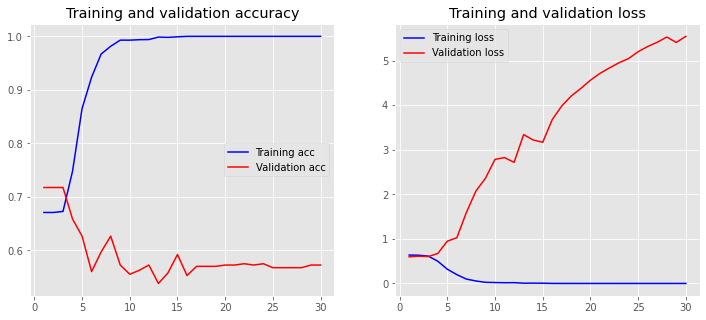

In [58]:
plot_history(history_gru)

In [55]:
from keras.models import load_model
gru_model = load_model('/content/drive/MyDrive/model_gru_hw5-001-0.717445.ckpt')

In [56]:
gru_model.evaluate([test_sent1_seq, test_sent2_seq], y_test)
gru_preds = lstm_model.predict([test_sent1_seq, test_sent2_seq])

54/54 [==============================] - 2s 37ms/step


In [57]:
y_gru_pred = np.where(gru_preds > 0.5, 1, 0)
print(classification_report(y_test, y_gru_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.32      0.28      0.30       578
           1       0.66      0.71      0.68      1147

    accuracy                           0.56      1725
   macro avg       0.49      0.49      0.49      1725
weighted avg       0.55      0.56      0.55      1725



### Question 4

bilstm and lstm has more accuracy than gru. The loss of bilstm is smaller than lstm

### Question 5

higher weight in some words = more attention

Text(0, 0.5, 'weight')

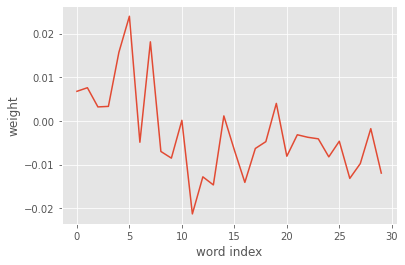

In [59]:
W = gru_model.layers[4].weights[1]
W = np.squeeze(W)
plt.plot(W)
plt.xlabel('word index')
plt.ylabel('weight')

Text(0, 0.5, 'weight')

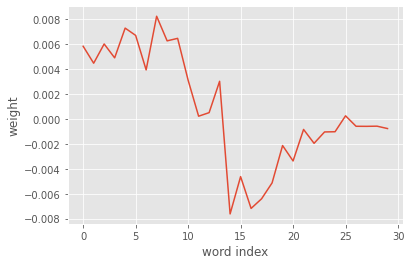

In [60]:
W = bilstm_model.layers[4].weights[1]
W = np.squeeze(W)
plt.plot(W)
plt.xlabel('word index')
plt.ylabel('weight')

Text(0, 0.5, 'weight')

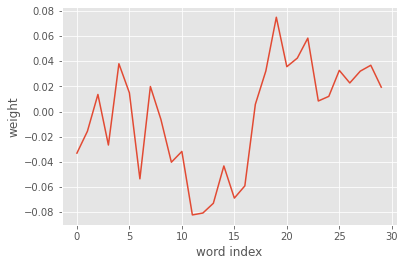

In [61]:
W = lstm_model.layers[4].weights[1]
W = np.squeeze(W)
plt.plot(W)
plt.xlabel('word index')
plt.ylabel('weight')